In [1]:
import os
import sys
import yaml
import copy

import numpy as np
import pandas as pd
import xarray as xr

In [2]:
sys.path.insert(0, os.path.realpath('../libs/'))
import graph_utils as gu
#import verif_utils as vu

In [3]:
import cmaps
# graph tools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.colorbar as cbar
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature

%matplotlib inline

## Locations

In [4]:
def smooth_preserve_scale(da, win_lat=7, win_lon=7, eps=1e-12):
    mu = da.rolling(lat=win_lat, lon=win_lon, center=True, min_periods=1).mean()
    sig = da.rolling(lat=win_lat, lon=win_lon, center=True, min_periods=1).std()

    z = (da - mu) / (sig + eps)
    z_s = z.rolling(lat=win_lat, lon=win_lon, center=True, min_periods=1).mean()

    return mu + z_s * sig

## Geo info

In [5]:
ds_static = xr.open_zarr('/glade/derecho/scratch/ksha/EPRI_data/static/static.zarr')
lon = ds_static['lon'].values
lat = ds_static['lat'].values

In [6]:
gridx, gridy = np.meshgrid(lon, lat)

## Map creation

In [7]:
scale_param = '50m'

PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

def map_gridline_opt(ax):
    '''
    Customize cartopy map gridlines
    '''
    # lat/lon gridlines and labeling

    GL = ax.gridlines(crs=ccrs.PlateCarree(), 
                      draw_labels=False, x_inline=False, y_inline=False, 
                      color='k', linewidth=0.0, linestyle=':', zorder=5)
    GL.top_labels = None; GL.bottom_labels = None
    GL.right_labels = None; GL.left_labels = None
    GL.xlabel_style = {'size': 14}; GL.ylabel_style = {'size': 14}
    GL.rotate_labels = False
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='-', linewidth=1.5, zorder=7)
    ax.add_feature(PROVINCE, edgecolor='0.25', linestyle='-', linewidth=1.5, zorder=7)
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param ), edgecolor='k', linewidth=1.5, zorder=5)
    ax.spines['geo'].set_linewidth(2.5)
    return ax

### Geo-Info

In [8]:
ds_static = xr.open_zarr('/glade/derecho/scratch/ksha/EPRI_data/static/static.zarr')
lon = ds_static['lon'].values
lat = ds_static['lat'].values

dict_loc = {
    'Pituffik': (76.4, -68.575),
    'Fairbanks': (64.75, -147.4),
    'Guam': (13.475, 144.75),
    'Yuma_PG': (33.125, -114.125),
    'Fort_Bragg': (35.05, -79.115),
}

dict_latlon = {}

keys = list(dict_loc.keys())

# ---- plot each station into one panel ----
stn_pad = 7.5      # deg
map_edge_pad = 2.5 # deg

for i, key in enumerate(keys):
    stn_lat, stn_lon = dict_loc[key]

    domain = [
        stn_lon - stn_pad,
        stn_lon + stn_pad,
        stn_lat - stn_pad,
        stn_lat + stn_pad
    ]

    map_extent = [
        domain[0] - map_edge_pad,
        domain[1] + map_edge_pad,
        domain[2] - map_edge_pad,
        domain[3] + map_edge_pad
    ]
    dict_latlon[key] = map_extent

### Yuma PG

In [9]:
key = 'Yuma_PG'
base_dir = f'/glade/derecho/scratch/ksha/EPRI_data/METRICS/{key}/'

fn = base_dir + 'ACC_TP_max.zarr'
ds_ACC_TP = xr.open_zarr(fn)
ds_ACC_TP_plot = ds_ACC_TP.map(lambda da: smooth_preserve_scale(da, 5, 5))


fn = base_dir + 'ACC_p999_event.zarr'
ds_ACC_SEDI_all = xr.open_zarr(fn)
ds_ACC_SEDI_all = ds_ACC_SEDI_all.rename({'lead': 'year_valid'})
ds_ACC_SEDI_all_plot = ds_ACC_SEDI_all.map(lambda da: smooth_preserve_scale(da, 7, 7))

fn = base_dir + 'ACC_SPEI.zarr'
ds_ACC_SPEI = xr.open_zarr(fn)
ds_ACC_SPEI_plot = ds_ACC_SPEI.map(lambda da: smooth_preserve_scale(da, 5, 5))

mask_on_reg = ds_static['land_sea_mask'].sel(lat=ds_ACC_TP.lat, lon=ds_ACC_TP.lon)

for var_ in list(ds_ACC_SPEI.keys()):
    ds_ACC_SPEI[var_] = ds_ACC_SPEI[var_].where(mask_on_reg > 0.5)
    ds_ACC_SPEI_plot[var_] = ds_ACC_SPEI_plot[var_].where(mask_on_reg > 0.5)


stn_lat, stn_lon = dict_loc[key]

In [10]:
lat = ds_ACC_TP['lat'].values
lon = ds_ACC_TP['lon'].values
gridx, gridy = np.meshgrid(lon, lat)

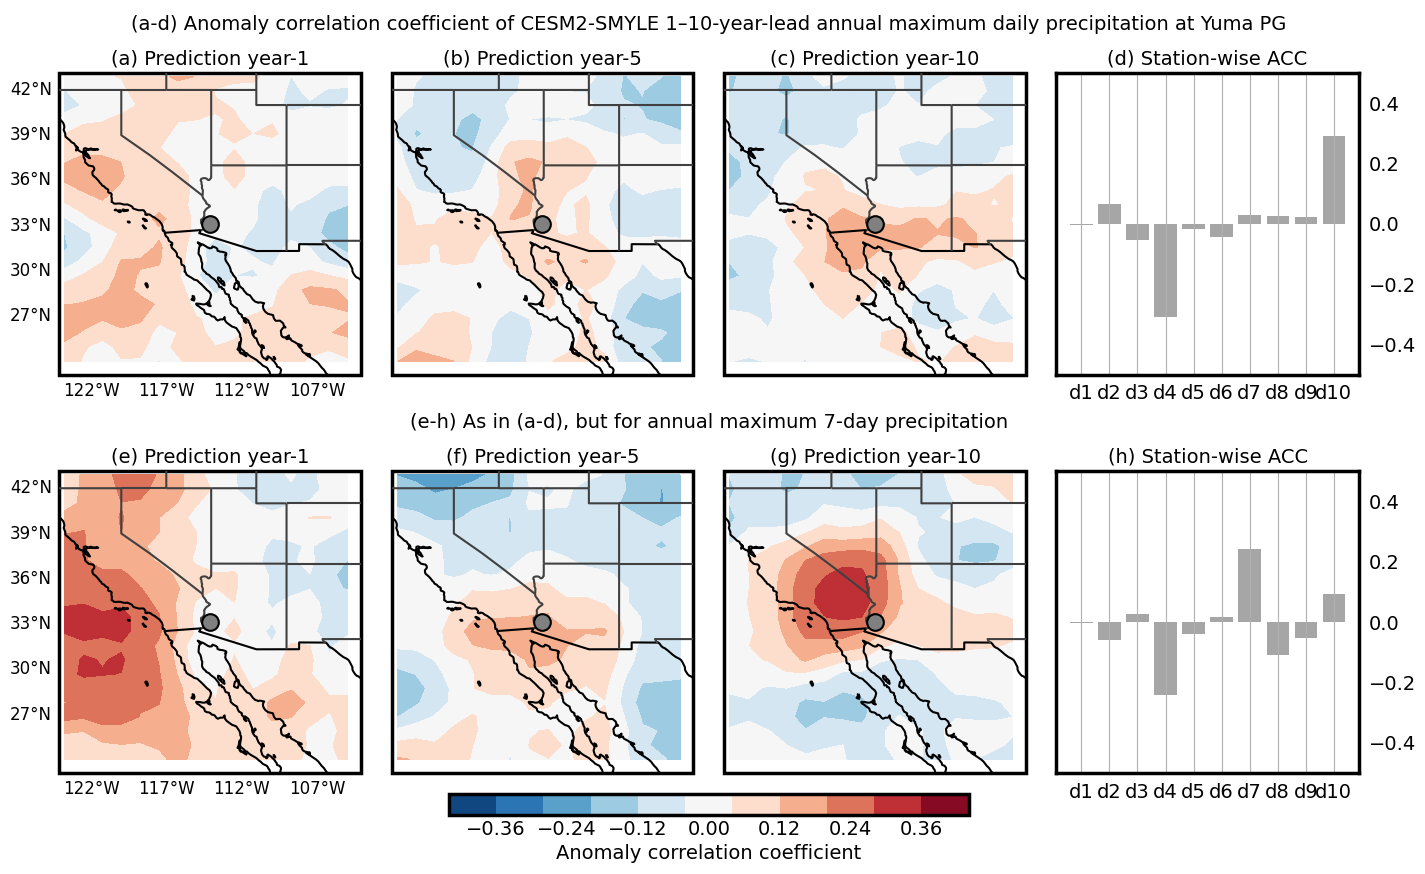

In [11]:
fig = plt.figure(figsize=(13, 7))
proj_ = ccrs.PlateCarree()

N_row = 2
N_col = 4

gs = gridspec.GridSpec(N_row, N_col, height_ratios=[1,]*N_row, width_ratios=[1,]*N_col)

AX_map = []
AX_line = []

for n in range(N_row):
    for m in range(N_col-1):
        AX_map.append(plt.subplot(gs[n, m], projection=proj_))
    AX_line.append(plt.subplot(gs[n, N_col-1]))

plt.subplots_adjust(0, 0, 1, 1, hspace=0.32, wspace=0.1)

for i_ax, ax in enumerate(AX_map):
    ax.set_extent(dict_latlon[key], crs=proj_)
    ax = map_gridline_opt(ax)
    if i_ax == 0 or i_ax == 3:
        GL = ax.gridlines(
            crs=ccrs.PlateCarree(),
            draw_labels=True, x_inline=False, y_inline=False,
            color='k', linewidth=0, linestyle=':', zorder=5
        )
        GL.top_labels = None
        GL.right_labels = None
        GL.xlabel_style = {'size': 12}
        GL.ylabel_style = {'size': 12}
        GL.xlocator = ticker.FixedLocator([-122, -117, -112, -107])
        GL.ylocator = ticker.FixedLocator([27, 30, 33, 36, 39, 42])

fake_x = np.arange(1, 11)

for ax in AX_line:
    ax = gu.ax_decorate_box(ax)
    ax.set_ylim([-0.5, 0.5])
    # ax.set_xlim([0.5, 10.5])
    ax.grid(axis='x')
    ax.tick_params(labelbottom=True, labelright=True, labelsize=14)
    ax.set_xticks(fake_x)
    ax.set_xticklabels(['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10'])

# ================================================ #

LEADs = [0, 4, 9]
vmin = -0.4
vmax = 0.4
levels = np.arange(-0.44, 0.4+0.08, 0.08)
# norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

text_abs = ['(a)', '(b)', '(c)', '(e)', '(f)', '(g)']

for i_lead, lead in enumerate(LEADs):
    AX_map[i_lead].contourf(
        gridx, gridy, ds_ACC_TP_plot['PRECT_max'].isel(year_valid=lead).values, 
        levels=levels, cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree()
    )
    # AX_map[i_lead].contour(
    #     gridx, gridy, ds_ACC_TP_plot['PRECT_max'].isel(year_valid=lead).values, 
    #     levels=[0,], colors=('k',), linestyles=(':',), linewidths=(2.5,), transform=ccrs.PlateCarree()
    # )

    AX_map[i_lead].plot(stn_lon, stn_lat, 'ko', mew=1.5, mfc='0.5', mec='k', ms=12, transform=ccrs.PlateCarree(), zorder=9)
    
    CS = AX_map[3+i_lead].contourf(
        gridx, gridy, ds_ACC_TP_plot['PRECT_7d_max'].isel(year_valid=lead).values, 
        levels=levels, cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree()
    )
    # AX_map[3+i_lead].contour(
    #     gridx, gridy, ds_ACC_TP_plot['PRECT_7d_max'].isel(year_valid=lead).values, 
    #     levels=[0,], colors=('k',), linestyles=(':',), linewidths=(2.5,), transform=ccrs.PlateCarree()
    # )

    AX_map[3+i_lead].plot(stn_lon, stn_lat, 'ko', mew=1.5, mfc='0.5', mec='k', ms=12, transform=ccrs.PlateCarree(), zorder=9)
    
    AX_map[i_lead].set_title(text_abs[i_lead]+f' Prediction year-{lead+1}', fontsize=14)
    AX_map[3+i_lead].set_title(text_abs[3+i_lead]+f' Prediction year-{lead+1}', fontsize=14)

AX_line[0].bar(fake_x, ds_ACC_TP['PRECT_max'].isel(lat=10, lon=8).values, facecolor='0.65', edgecolor='k', linewidth=0)
AX_line[1].bar(fake_x, ds_ACC_TP['PRECT_7d_max'].isel(lat=10, lon=8).values, facecolor='0.65', edgecolor='k', linewidth=0)

AX_line[0].set_title('(d) Station-wise ACC', fontsize=14)
AX_line[1].set_title('(h) Station-wise ACC', fontsize=14)

#
ax_base = fig.add_axes([0.3, -0.13, 0.4, 0.1])#
ax_base.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax = inset_axes(ax_base, height='30%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='horizontal', cax=cax, ticks=[-0.36, -0.24, -0.12, 0, 0.12, 0.24, 0.36])
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.ax.set_xlabel('Anomaly correlation coefficient', fontsize=14)

ax_title1 = fig.add_axes([0.0, 1.05, 1.0, 0.04])
ax_title1.text(
    0.5, 0.5, 
    '(a-d) Anomaly correlation coefficient of CESM2-SMYLE 1–10-year-lead annual maximum daily precipitation at Yuma PG', 
    fontsize=14, va='center', ha='center', transform=ax_title1.transAxes
)

ax_title2 = fig.add_axes([0.0, 0.48, 1.0, 0.04])
ax_title2.text(
    0.5, 0.5, 
    '(e-h) As in (a-d), but for annual maximum 7-day precipitation', 
    fontsize=14, va='center', ha='center', transform=ax_title2.transAxes
)

ax_base.set_axis_off()
ax_title1.set_axis_off()
ax_title2.set_axis_off()

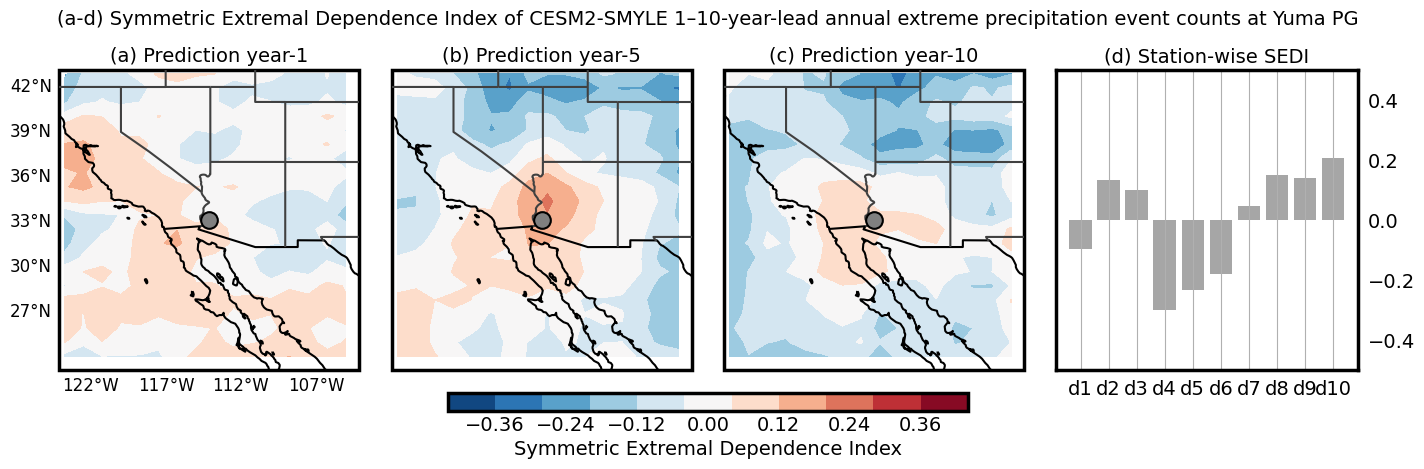

In [12]:
fig = plt.figure(figsize=(13, 3))
proj_ = ccrs.PlateCarree()

N_row = 1
N_col = 4

gs = gridspec.GridSpec(N_row, N_col, height_ratios=[1,]*N_row, width_ratios=[1,]*N_col)

AX_map = []
AX_line = []

for n in range(N_row):
    for m in range(N_col-1):
        AX_map.append(plt.subplot(gs[n, m], projection=proj_))
    AX_line.append(plt.subplot(gs[n, N_col-1]))

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.1)

for i_ax, ax in enumerate(AX_map):
    ax.set_extent(dict_latlon[key], crs=proj_)
    ax = map_gridline_opt(ax)
    if i_ax == 0 or i_ax == 3:
        GL = ax.gridlines(
            crs=ccrs.PlateCarree(),
            draw_labels=True, x_inline=False, y_inline=False,
            color='k', linewidth=0, linestyle=':', zorder=5
        )
        GL.top_labels = None
        GL.right_labels = None
        GL.xlabel_style = {'size': 12}
        GL.ylabel_style = {'size': 12}
        GL.xlocator = ticker.FixedLocator([-122, -117, -112, -107])
        GL.ylocator = ticker.FixedLocator([27, 30, 33, 36, 39, 42])

fake_x = np.arange(1, 11)

for ax in AX_line:
    ax = gu.ax_decorate_box(ax)
    ax.set_ylim([-0.5, 0.5])
    # ax.set_xlim([0.5, 10.5])
    ax.grid(axis='x')
    ax.tick_params(labelbottom=True, labelright=True, labelsize=14)
    ax.set_xticks(fake_x)
    ax.set_xticklabels(['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10'])

# ================================================ #

LEADs = [0, 4, 9]
vmin = -0.4
vmax = 0.4
levels = np.arange(-0.44, 0.4+0.08, 0.08)

text_abs = ['(a)', '(b)', '(c)', '(e)', '(f)', '(g)']

for i_lead, lead in enumerate(LEADs):
    CS = AX_map[i_lead].contourf(
        gridx, gridy, ds_ACC_SEDI_all_plot['PRECT_SEDI'].isel(year_valid=lead).values, 
        levels=levels, cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree()
    )

    AX_map[i_lead].plot(stn_lon, stn_lat, 'ko', mew=1.5, mfc='0.5', mec='k', ms=12, transform=ccrs.PlateCarree(), zorder=9)
    AX_map[i_lead].set_title(text_abs[i_lead]+f' Prediction year-{lead+1}', fontsize=14)

AX_line[0].bar(fake_x, ds_ACC_SEDI_all['PRECT_SEDI'].isel(lat=10, lon=8).values, facecolor='0.65', edgecolor='k', linewidth=0)
AX_line[0].set_title('(d) Station-wise SEDI', fontsize=14)
#
ax_base = fig.add_axes([0.3, -0.275, 0.4, 0.2])#
ax_base.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax = inset_axes(ax_base, height='30%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='horizontal', cax=cax, ticks=[-0.36, -0.24, -0.12, 0, 0.12, 0.24, 0.36])
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.ax.set_xlabel('Symmetric Extremal Dependence Index', fontsize=14)

ax_title1 = fig.add_axes([0.0, 1.15, 1.0, 0.04])
ax_title1.text(
    0.5, 0.5, 
    '(a-d) Symmetric Extremal Dependence Index of CESM2-SMYLE 1–10-year-lead annual extreme precipitation event counts at Yuma PG', 
    fontsize=14, va='center', ha='center', transform=ax_title1.transAxes
)

ax_base.set_axis_off()
ax_title1.set_axis_off()

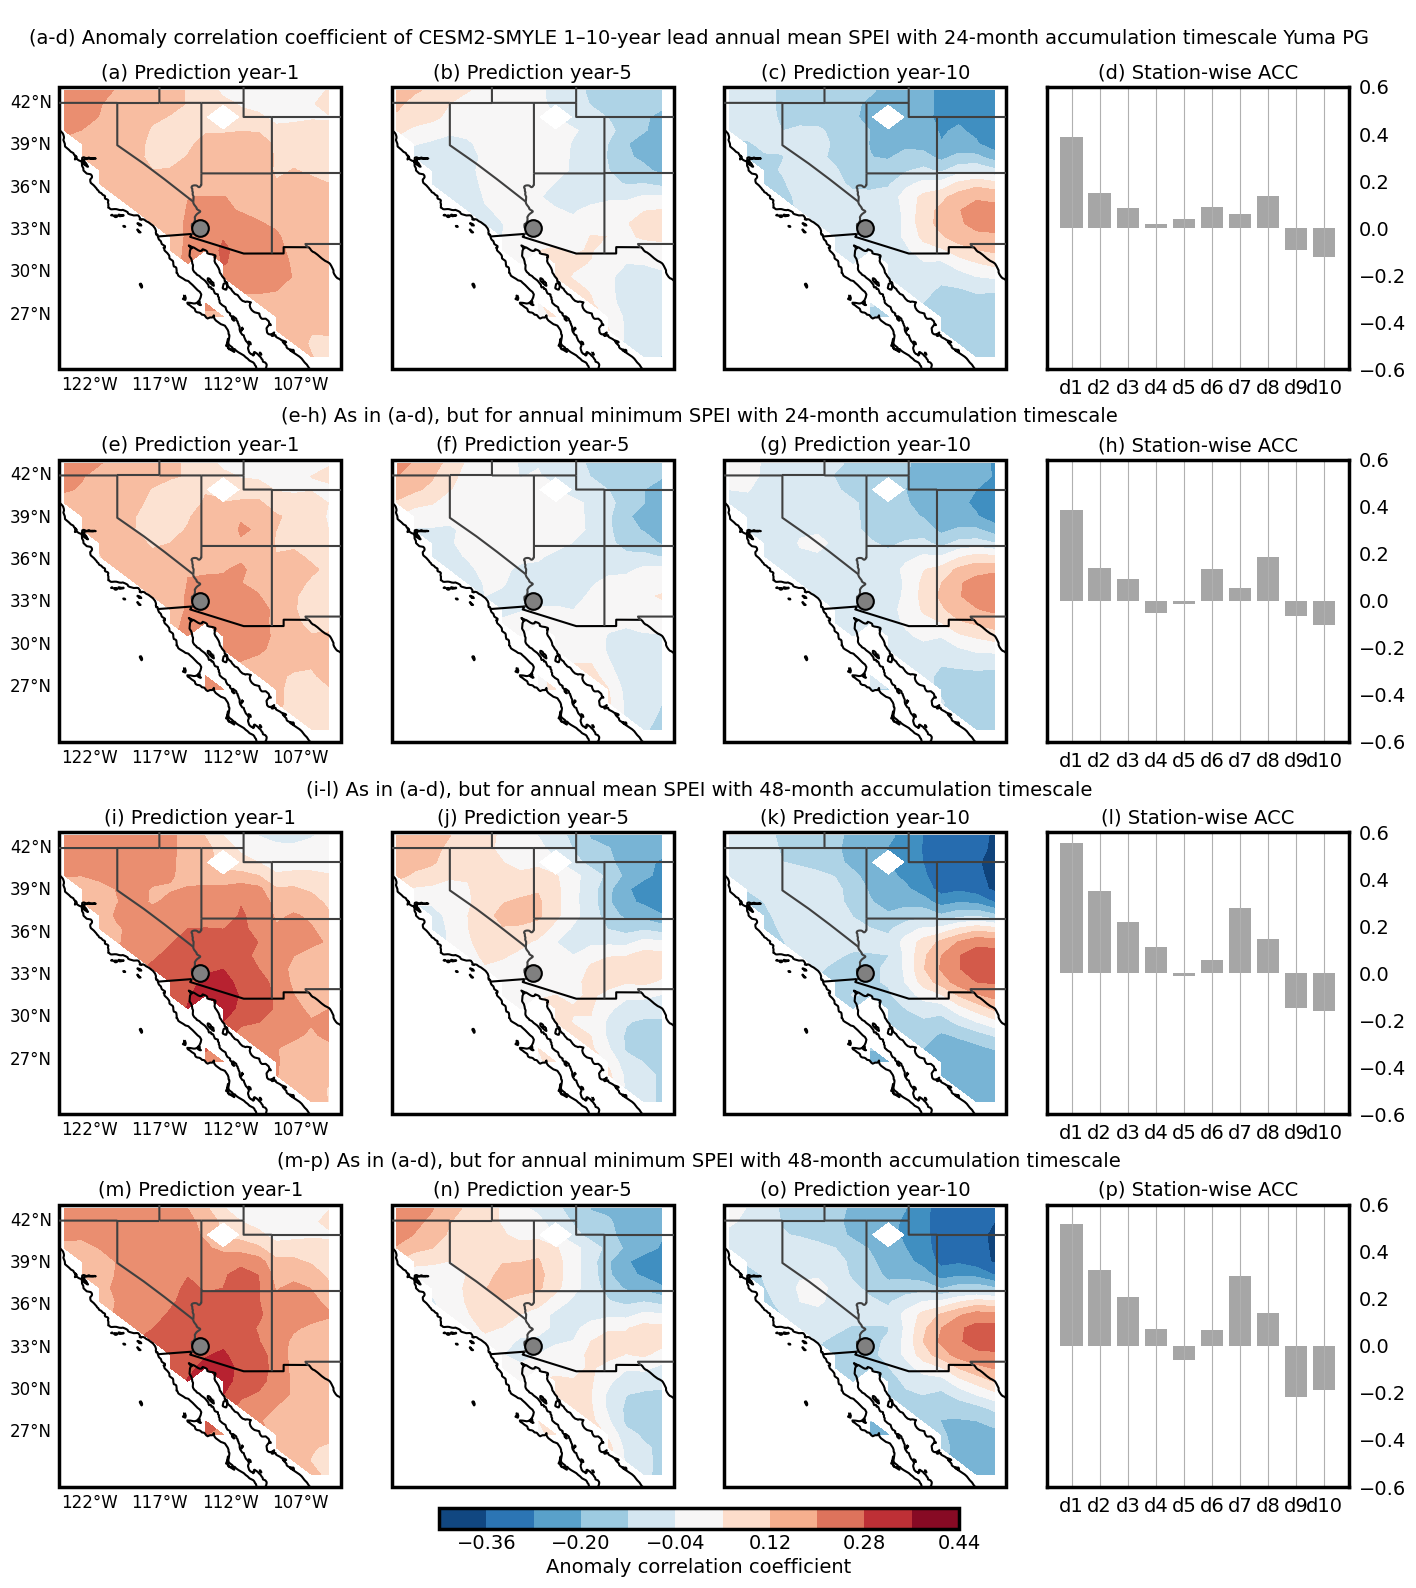

In [13]:
fig = plt.figure(figsize=(13, 14))
proj_ = ccrs.PlateCarree()

N_row = 4
N_col = 4

gs = gridspec.GridSpec(N_row, N_col, height_ratios=[1,]*N_row, width_ratios=[1,]*N_col)

AX_map = []
AX_line = []

for n in range(N_row):
    for m in range(N_col-1):
        AX_map.append(plt.subplot(gs[n, m], projection=proj_))
    AX_line.append(plt.subplot(gs[n, N_col-1]))

plt.subplots_adjust(0, 0, 1, 1, hspace=0.32, wspace=0.1)

for i_ax, ax in enumerate(AX_map):
    ax.set_extent(dict_latlon[key], crs=proj_)
    ax = map_gridline_opt(ax)
    if i_ax in [0, 3, 6, 9]:
        GL = ax.gridlines(
            crs=ccrs.PlateCarree(),
            draw_labels=True, x_inline=False, y_inline=False,
            color='k', linewidth=0, linestyle=':', zorder=5
        )
        GL.top_labels = None
        GL.right_labels = None
        GL.xlabel_style = {'size': 12}
        GL.ylabel_style = {'size': 12}
        GL.xlocator = ticker.FixedLocator([-122, -117, -112, -107])
        GL.ylocator = ticker.FixedLocator([27, 30, 33, 36, 39, 42])

fake_x = np.arange(1, 11)

for ax in AX_line:
    ax = gu.ax_decorate_box(ax)
    ax.set_ylim([-0.6, 0.6])
    # ax.set_xlim([0.5, 10.5])
    ax.grid(axis='x')
    ax.tick_params(labelbottom=True, labelright=True, labelsize=14)
    ax.set_xticks(fake_x)
    ax.set_xticklabels(['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10'])

# ================================================ #

LEADs = [0, 4, 9]
levels = np.arange(-0.72, 0.72+0.12, 0.12)
# norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

text_abs = ['(a)', '(b)', '(c)', 
            '(e)', '(f)', '(g)',
            '(i)', '(j)', '(k)',
            '(m)', '(n)', '(o)']

for i_lead, lead in enumerate(LEADs):
    AX_map[i_lead].contourf(
        gridx, gridy, ds_ACC_SPEI_plot['SPEI_24_mean'].isel(year_valid=lead).values, 
        levels=levels, cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree()
    )
    AX_map[i_lead].plot(stn_lon, stn_lat, 'ko', mew=1.5, mfc='0.5', mec='k', ms=12, transform=ccrs.PlateCarree(), zorder=9)
    
    AX_map[3+i_lead].contourf(
        gridx, gridy, ds_ACC_SPEI_plot['SPEI_24_min'].isel(year_valid=lead).values, 
        levels=levels, cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree()
    )
    AX_map[3+i_lead].plot(stn_lon, stn_lat, 'ko', mew=1.5, mfc='0.5', mec='k', ms=12, transform=ccrs.PlateCarree(), zorder=9)

    AX_map[6+i_lead].contourf(
        gridx, gridy, ds_ACC_SPEI_plot['SPEI_48_mean'].isel(year_valid=lead).values, 
        levels=levels, cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree()
    )
    AX_map[6+i_lead].plot(stn_lon, stn_lat, 'ko', mew=1.5, mfc='0.5', mec='k', ms=12, transform=ccrs.PlateCarree(), zorder=9)
    
    AX_map[9+i_lead].contourf(
        gridx, gridy, ds_ACC_SPEI_plot['SPEI_48_min'].isel(year_valid=lead).values, 
        levels=levels, cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree()
    )
    AX_map[9+i_lead].plot(stn_lon, stn_lat, 'ko', mew=1.5, mfc='0.5', mec='k', ms=12, transform=ccrs.PlateCarree(), zorder=9)
    
    AX_map[i_lead].set_title(text_abs[i_lead]+f' Prediction year-{lead+1}', fontsize=14)
    AX_map[3+i_lead].set_title(text_abs[3+i_lead]+f' Prediction year-{lead+1}', fontsize=14)
    AX_map[6+i_lead].set_title(text_abs[6+i_lead]+f' Prediction year-{lead+1}', fontsize=14)
    AX_map[9+i_lead].set_title(text_abs[9+i_lead]+f' Prediction year-{lead+1}', fontsize=14)
    

AX_line[0].bar(fake_x, ds_ACC_SPEI['SPEI_24_mean'].isel(lat=10, lon=8).values, facecolor='0.65', edgecolor='k', linewidth=0)
AX_line[1].bar(fake_x, ds_ACC_SPEI['SPEI_24_min'].isel(lat=10, lon=8).values, facecolor='0.65', edgecolor='k', linewidth=0)
AX_line[2].bar(fake_x, ds_ACC_SPEI['SPEI_48_mean'].isel(lat=10, lon=8).values, facecolor='0.65', edgecolor='k', linewidth=0)
AX_line[3].bar(fake_x, ds_ACC_SPEI['SPEI_48_min'].isel(lat=10, lon=8).values, facecolor='0.65', edgecolor='k', linewidth=0)


AX_line[0].set_title('(d) Station-wise ACC', fontsize=14)
AX_line[1].set_title('(h) Station-wise ACC', fontsize=14)
AX_line[2].set_title('(l) Station-wise ACC', fontsize=14)
AX_line[3].set_title('(p) Station-wise ACC', fontsize=14)

#
ax_base = fig.add_axes([0.3, -0.065, 0.4, 0.05])#
ax_base.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax = inset_axes(ax_base, height='30%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='horizontal', cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.ax.set_xlabel('Anomaly correlation coefficient', fontsize=14)

ax_title1 = fig.add_axes([0.0, 1.015, 1.0, 0.04])
ax_title1.text(
    0.5, 0.5, 
    '(a-d) Anomaly correlation coefficient of CESM2-SMYLE 1–10-year lead annual mean SPEI with 24-month accumulation timescale Yuma PG', 
    fontsize=14, va='center', ha='center', transform=ax_title1.transAxes
)

ax_title2 = fig.add_axes([0.0, 0.745, 1.0, 0.04])
ax_title2.text(
    0.5, 0.5, 
    '(e-h) As in (a-d), but for annual minimum SPEI with 24-month accumulation timescale', 
    fontsize=14, va='center', ha='center', transform=ax_title2.transAxes
)

ax_title3 = fig.add_axes([0.0, 0.4775, 1.0, 0.04])
ax_title3.text(
    0.5, 0.5, 
    '(i-l) As in (a-d), but for annual mean SPEI with 48-month accumulation timescale', 
    fontsize=14, va='center', ha='center', transform=ax_title3.transAxes
)

ax_title4 = fig.add_axes([0.0, 0.2125, 1.0, 0.04])
ax_title4.text(
    0.5, 0.5, 
    '(m-p) As in (a-d), but for annual minimum SPEI with 48-month accumulation timescale', 
    fontsize=14, va='center', ha='center', transform=ax_title4.transAxes
)

ax_base.set_axis_off()
ax_title1.set_axis_off()
ax_title2.set_axis_off()
ax_title3.set_axis_off()
ax_title4.set_axis_off()